In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("GermanCredit.csv")

print("Original DataFrame Info:")
print(f"Shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print("\nSample data:")
print(df.head())

print("\nColumns with 'none' values:")
none_counts = {}
for col in df.columns:
    none_count = df[col].astype(str).str.lower().str.count('none').sum()
    if none_count > 0:
        none_counts[col] = none_count
        print(f"  - {col}: {none_count} none values")

def drop_least_contributing_columns(dataframe, n=3):
    none_counts = {}
    for col in dataframe.columns:
        # Count non-zero 'none' values (case insensitive)
        none_count = dataframe[col].astype(str).str.lower().str.count('none').sum()
        none_counts[col] = none_count
        
    sorted_columns = sorted(none_counts.items(), key=lambda x: (-x[1], x[0]))
    columns_to_drop = [col for col, count in sorted_columns[:n]]
    print(f"Dropping columns: {columns_to_drop}")
    return dataframe.drop(columns=columns_to_drop)

df_cleaned = drop_least_contributing_columns(df, n=3)

print("\nAfter dropping columns:")
print(f"Shape: {df_cleaned.shape}")
print(f"Column names: {df_cleaned.columns.tolist()}")

print("\nUnique values in checking_status:")
print(df_cleaned['checking_status'].unique() if 'checking_status' in df_cleaned.columns else "Column not found")

print("\nUnique values in savings_status:")
print(df_cleaned['savings_status'].unique() if 'savings_status' in df_cleaned.columns else "Column not found")


Original DataFrame Info:
Shape: (1000, 21)
Column names: ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']

Sample data:
  checking_status  duration                    credit_history  \
0            '<0'         6  'critical/other existing credit'   
1      '0<=X<200'        48                   'existing paid'   
2   'no checking'        12  'critical/other existing credit'   
3            '<0'        42                   'existing paid'   
4            '<0'        24              'delayed previously'   

               purpose  credit_amount      savings_status employment  \
0             radio/tv           1169  'no known savings'      '>=7'   
1             radio/tv           5951              

In [145]:
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = df_cleaned[col].str.replace("'", "")
print("After removing apostrophes")
print(df_cleaned['checking_status'].unique())
print(df_cleaned['savings_status'].unique())

#map checking_status values
checking_status_mapping = {
    'no checking': 'No Checking',
    '<0': 'Low',
    '0<=X<200': 'Medium',
    '>=200': 'High'
}
df_cleaned['checking_status'] = df_cleaned['checking_status'].map(checking_status_mapping)

print("\nAfter mapping checking_status:")
print(df_cleaned['checking_status'].value_counts())

#map savings_status values
saving_status_mapping = {
    'no known savings': 'No Savings',
    '<100': 'Low',
    '100<=X<500': 'Medium',
    '500<=X<1000': 'High',
    '>=1000': 'High'
}
df_cleaned['savings_status'] = df_cleaned['savings_status'].map(saving_status_mapping)

print("\nAfter mapping savings_status:")
print(df_cleaned['savings_status'].value_counts())

After removing apostrophes
['<0' '0<=X<200' 'no checking' '>=200']
['no known savings' '<100' '500<=X<1000' '>=1000' '100<=X<500']

After mapping checking_status:
checking_status
No Checking    394
Low            274
Medium         269
High            63
Name: count, dtype: int64

After mapping savings_status:
savings_status
Low           603
No Savings    183
High          111
Medium        103
Name: count, dtype: int64


In [146]:
print(df_cleaned['employment'].unique())

['>=7' '1<=X<4' '4<=X<7' 'unemployed' '<1']


In [147]:
#change class column values
df_cleaned['class'] = df_cleaned['class'].map({'good': 1, 'bad': 0})

#change employment column values
employment_mapping = {
    'unemployed': 'Unemployed',
    '<1': 'Amateur',
    '1<=X<4': 'Professional', 
    '4<=X<7': 'Experienced',
    '>=7': 'Expert'
}
df_cleaned['employment'] = df_cleaned['employment'].map(employment_mapping)

print("After mapping employment:")
print(df_cleaned['employment'].value_counts())

After mapping employment:
employment
Professional    339
Expert          253
Experienced     174
Amateur         172
Unemployed       62
Name: count, dtype: int64


In [148]:
foreign_worker_class = pd.crosstab(df_cleaned['foreign_worker'], df_cleaned['class'])
print("\nForeign worker by class counts:")
print(foreign_worker_class)


Foreign worker by class counts:
class             0    1
foreign_worker          
no                4   33
yes             296  667


In [149]:
#cross-tabulation of employment and savings_status
employment_savings_counts = pd.crosstab(df_cleaned['employment'], df_cleaned['savings_status'])
print("\nCount of employment categories by savings status:")
print(employment_savings_counts)


Count of employment categories by savings status:
savings_status  High  Low  Medium  No Savings
employment                                   
Amateur           12  120      17          23
Experienced       18  100      24          32
Expert            34  133      22          64
Professional      44  210      33          52
Unemployed         3   40       7          12


In [150]:
#average credit_amount of single males with 4<=X<7 years of employment
single_males_experienced = df_cleaned[
    (df_cleaned['personal_status'] == 'male single') &
    (df_cleaned['employment'] == 'Experienced')
]

#average credit amount
avg_credit_single_males = single_males_experienced['credit_amount'].mean()
print(f"\nAverage credit amount for single males with Experienced employment: {avg_credit_single_males}")


Average credit amount for single males with Experienced employment: 4142.592592592592


In [151]:
#average credit duration for each of the job types
avg_duration_by_job = df_cleaned.groupby('job')['duration'].mean()

print("\nAverage credit duration by job type:")
print(avg_duration_by_job)


Average credit duration by job type:
job
high qualif/self emp/mgmt    25.168919
skilled                      21.411111
unemp/unskilled non res      17.363636
unskilled resident           16.535000
Name: duration, dtype: float64


In [152]:
#most common checking_status and savings_status for 'education' purpose 
education_df = df_cleaned[df_cleaned['purpose'] == 'education']
most_common_checking = education_df['checking_status'].mode()[0]
most_common_savings = education_df['savings_status'].mode()[0]

print("\nFor purpose 'education':")
print(f"Most common checking status: {most_common_checking}")
print(f"Most common savings status: {most_common_savings}")


For purpose 'education':
Most common checking status: No Checking
Most common savings status: Low


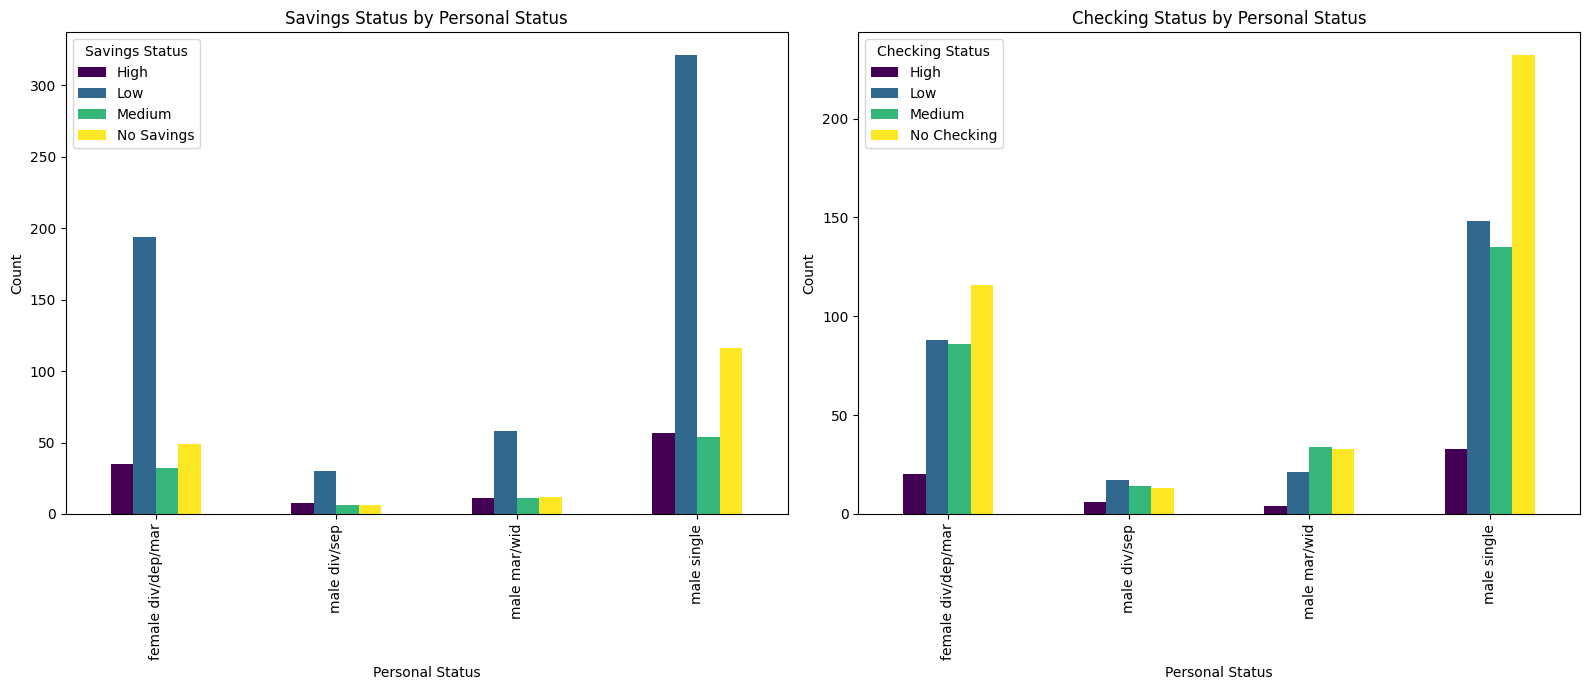

In [153]:
#visualization 
#subplots of two bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
#savings_status to personal_status
savings_personal = pd.crosstab(df_cleaned['personal_status'], df_cleaned['savings_status'])
savings_personal.plot(kind='bar', ax=ax1, colormap='viridis')
ax1.set_title('Savings Status by Personal Status')
ax1.set_xlabel('Personal Status')
ax1.set_ylabel('Count')
ax1.legend(title='Savings Status')
#checking_status to personal_status
checking_personal = pd.crosstab(df_cleaned['personal_status'], df_cleaned['checking_status'])
checking_personal.plot(kind='bar', ax=ax2, colormap='viridis')
ax2.set_title('Checking Status by Personal Status')
ax2.set_xlabel('Personal Status')
ax2.set_ylabel('Count')
ax2.legend(title='Checking Status')

plt.tight_layout()
plt.show()

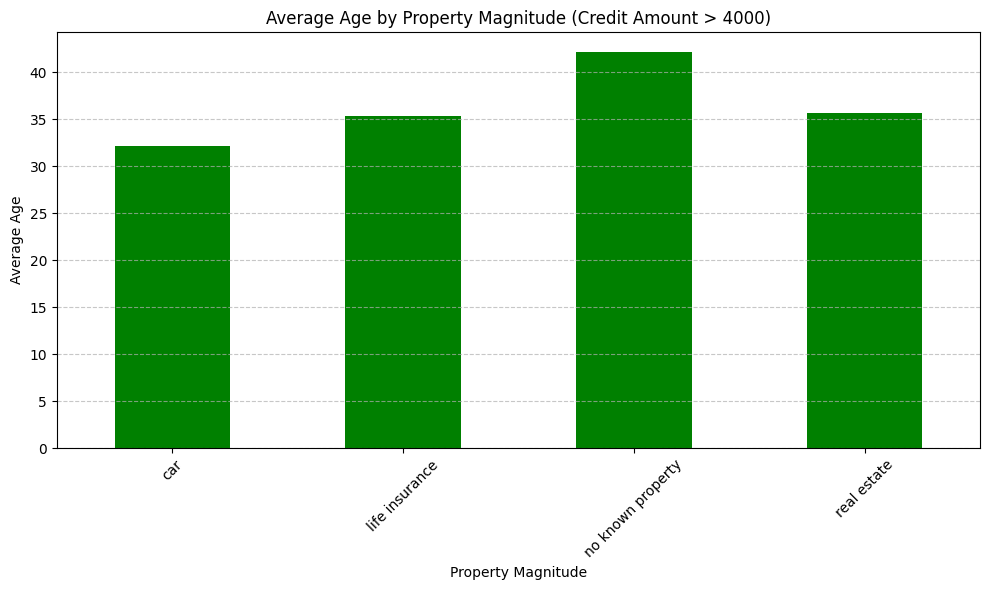

In [155]:
#bar graph of property_magnitude to average age for high credit amounts
#filter for people with credit_amount > 4000
high_credit = df_cleaned[df_cleaned['credit_amount'] > 4000]

avg_age_by_property = high_credit.groupby('property_magnitude')['age'].mean()

plt.figure(figsize=(10, 6))
avg_age_by_property.plot(kind='bar', color='green')
plt.title('Average Age by Property Magnitude (Credit Amount > 4000)')
plt.xlabel('Property Magnitude')
plt.ylabel('Average Age')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

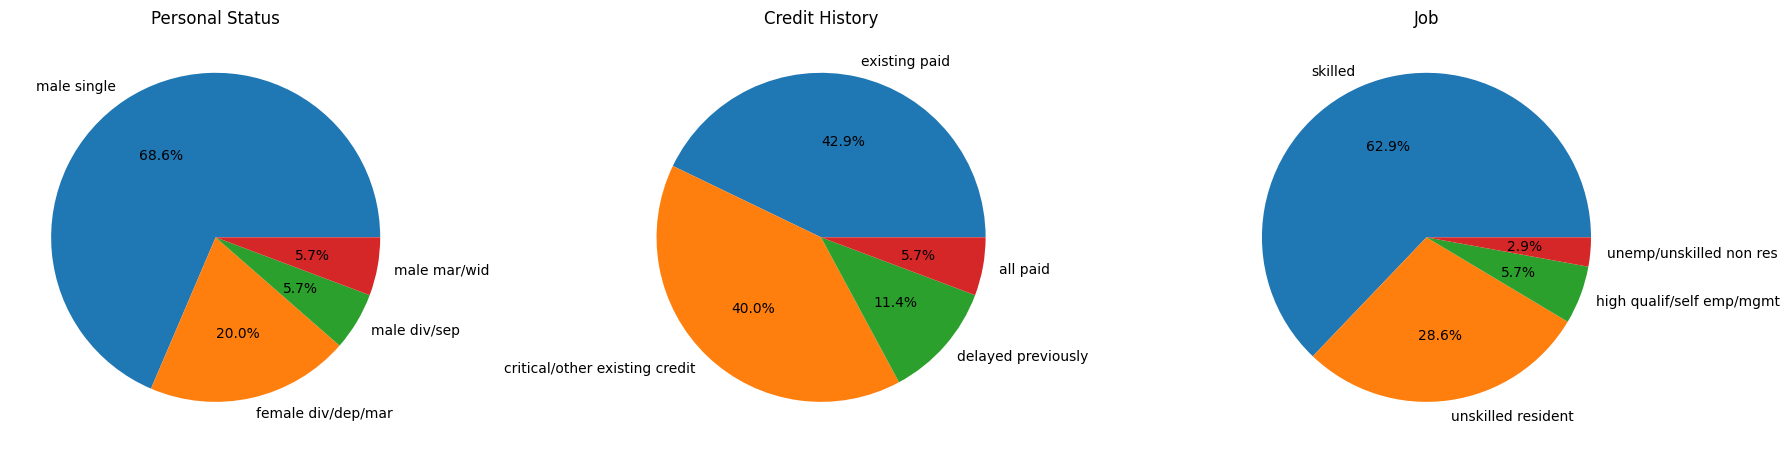

In [156]:
#pie charts for people with "High" savings_status and age above 40
filtered_df = df_cleaned[(df_cleaned['savings_status'] == 'High') & (df_cleaned['age'] > 40)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

filtered_df['personal_status'].value_counts().plot(kind='pie', ax=ax1, autopct='%1.1f%%')
ax1.set_title('Personal Status')
ax1.set_ylabel('')

filtered_df['credit_history'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Credit History')
ax2.set_ylabel('')

filtered_df['job'].value_counts().plot(kind='pie', ax=ax3, autopct='%1.1f%%')
ax3.set_title('Job')
ax3.set_ylabel('')

plt.tight_layout()
plt.show()